# NCI Dream Exome Sequencing Data Import

Exome sequencing data import for NCI DREAM drug sensitivity challenge.

Source data README: /Users/eczech/.synapseCache/428/756428/DREAM7_DrugSensitivity1_Exomeseq_README.txt

Field definitions from README:

- CellLine: Cell line name
- Tissue: Origin of variant (Somatic or Germline). Assumed to be "Germline" for cell lines due to lack of matched normal.
- dbSNP: dbSNP ID, if variant overlaps
- CancerGene?: Is the overlapping gene found in Sanger's Cancer Gene Census database.
- #Cosmic: Number of samples in COSMIC that have mutation at this position.
- Type: Variant effect (silent, missense, nonsense, frame-shifiting Indel, etc.)
- HGNC_ID: Overlapping gene
- Summary: Protein change
- Chromosome: Chromosome
- Start: Start position of variant
- Stop: Stop position of variant
- RefBase: Reference base
- AltBase: Alternate / variant base
- Confidence: Confidence in variant
- Zygosity(norm): Zygosity (hom, het) of matched normal sample (blank)
- RefCount(norm): # Reference alleles at position in matched normal (blank)
- AltCount(norm): # Alternate alleles at position in matched normal (blank)
- Zygosity(tumor): Zygosity (hom, het) of Cell Line
- RefCount(tumor): # Reference alleles at position in cell line
- AltCount(tumor): # Alternate alleles at position in cell line
- Avg#Mismatch(ref): METRIC: Average number of other mismatching bases in reads with reference base
- Avg#Mismatch(alt): METRIC: Average number of other mismatching bases in reads with variant
- MismatchQualitySum(ref): METRIC: Base quality sum of mismatching bases in reads with reference base
- MismatchQualitySum(alt): METRIC: Base quality sum of mismatching bases in reads with variant
- DistanceEffective3'End(ref): METRIC: Average normalized distance of reference bases from 3' end of their respective reads
- DistanceEffective3'End(alt): METRIC: Average normalized distance of variant bases from 3' end of their respective reads
- Details: Various other information collected at this position.

In [1]:
%run -m ipy_startup
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import excel_utils
from mgds.data_aggregation.import_lib import nci_dream
from py_utils import assertion_utils
from py_utils.collection_utils import subset

In [2]:
file_path = nci_dream.get_file('Exomeseq.txt')
d = pd.read_csv(file_path, sep='\t')

# Run manual conversions for known special cases in NCI Dream Gene Symbols
d['HGNC_ID'] = nci_dream.convert_hgnc_id(d['HGNC_ID'])

d.head()

,CellLine,Tissue,dbSNP,CancerGene?,#Cosmic,Type,HGNC_ID,Summary,Chromosome,Start,...,Zygosity(tumor),RefCount(tumor),AltCount(tumor),Avg#Mismatch(ref),Avg#Mismatch(alt),MismatchQualitySum(ref),MismatchQualitySum(alt),DistanceEffective3'end(ref),DistanceEffective3'end(alt),Details
0,184A1,Germline,.,No,0,Missense,TTLL10,p.G112R,1,1115548,...,het,66,53,0.273,0.396,3.606,4.075,0.282,0.285,TTLL10/uc001acy.2:Missense:p.G112R:TTLL10/uc01...
1,184A1,Germline,.,No,0,Missense,CPSF3L,p.T75I,1,1254635,...,het,24,46,0.542,0.761,4.333,4.196,0.547,0.423,CPSF3L/uc001aee.1:Intron:CPSF3L/uc001aef.1:Int...
2,184A1,Germline,.,No,0,Missense,CCNL2,p.R93P,1,1334409,...,het,6,29,0.333,1.345,0.500,3.966,0.550,0.246,CCNL2/uc001afi.2:Missense:p.R93P:CCNL2/uc001af...
3,184A1,Germline,.,No,0,Missense,ATAD3C,p.G337R,1,1398008,...,het,58,62,0.138,0.032,1.879,0.306,0.547,0.605,ATAD3C/uc001aft.2:Missense:p.G337R
4,184A1,Germline,.,No,0,Missense,ATAD3B,p.R579C,1,1430985,...,hom,0,327,0.000,0.257,0.000,2.813,0.000,0.469,ATAD3B/uc001afv.3:Missense:p.R579C:ATAD3B/uc00...


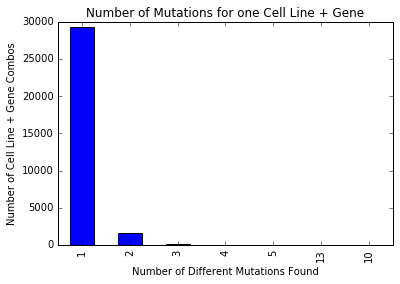

In [3]:
ax = d.groupby(['CellLine', 'HGNC_ID']).size().value_counts()\
    .plot(kind='bar', title='Number of Mutations for one Cell Line + Gene')
ax.set_xlabel('Number of Different Mutations Found')
ax.set_ylabel('Number of Cell Line + Gene Combos')

In [4]:
m_col = {
    'CellLine': 'CELL_LINE_ID',
    'Tissue': 'TISSUE', 
    'Type': 'SNP_TYPE',
    'CancerGene?': 'IS_SANGER_CANCER_GENE',
    '#Cosmic': 'NUM_COSMIC_SAMPLES',
    'HGNC_ID': 'GENE_ID:HGNC',
    'Confidence': 'CONFIDENCE',
    'RefBase': 'REF_BASE', 
    'AltBase': 'ALT_BASE',
    'Chromosome': 'CHROMOSOME',
    'Summary': 'SUMMARY',
    'Details': 'DETAILS',
    'Start': 'START',
    'Stop': 'STOP'
}
d = d[list(m_col.keys())].rename(columns=m_col)
d['SUMMARY'] = d['SUMMARY'].fillna('None')

# Ensure all objects are strings
assertion_utils.assert_object_types(d)

d.head()

,IS_SANGER_CANCER_GENE,ALT_BASE,CONFIDENCE,SNP_TYPE,TISSUE,START,STOP,SUMMARY,REF_BASE,CELL_LINE_ID,GENE_ID:HGNC,NUM_COSMIC_SAMPLES,DETAILS,CHROMOSOME
0,No,A,200,Missense,Germline,1115548,1115548,p.G112R,G,184A1,TTLL10,0,TTLL10/uc001acy.2:Missense:p.G112R:TTLL10/uc01...,1
1,No,A,200,Missense,Germline,1254635,1254635,p.T75I,G,184A1,CPSF3L,0,CPSF3L/uc001aee.1:Intron:CPSF3L/uc001aef.1:Int...,1
2,No,G,200,Missense,Germline,1334409,1334409,p.R93P,C,184A1,CCNL2,0,CCNL2/uc001afi.2:Missense:p.R93P:CCNL2/uc001af...,1
3,No,A,200,Missense,Germline,1398008,1398008,p.G337R,G,184A1,ATAD3C,0,ATAD3C/uc001aft.2:Missense:p.G337R,1
4,No,T,200,Missense,Germline,1430985,1430985,p.R579C,C,184A1,ATAD3B,0,ATAD3B/uc001afv.3:Missense:p.R579C:ATAD3B/uc00...,1


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33160 entries, 0 to 33159
Data columns (total 14 columns):
IS_SANGER_CANCER_GENE    33160 non-null object
ALT_BASE                 33160 non-null object
CONFIDENCE               33160 non-null int64
SNP_TYPE                 33160 non-null object
TISSUE                   33160 non-null object
START                    33160 non-null int64
STOP                     33160 non-null int64
SUMMARY                  33160 non-null object
REF_BASE                 33160 non-null object
CELL_LINE_ID             33160 non-null object
GENE_ID:HGNC             33160 non-null object
NUM_COSMIC_SAMPLES       33160 non-null int64
DETAILS                  33160 non-null object
CHROMOSOME               33160 non-null object
dtypes: int64(4), object(10)
memory usage: 3.5+ MB


## Convert Excel Dates as Gene IDs

In [6]:
d_exp = d.copy()
converted_gene_id = excel_utils.convert_gene_ids(d_exp['GENE_ID:HGNC'])
excel_utils.get_gene_conversions(d_exp['GENE_ID:HGNC'], converted_gene_id)

,ORIGINAL_GENE_ID,CONVERTED_GENE_ID
1377,7-Mar,MARCH7
10288,10-Mar,MARCH10
10890,6-Mar,MARCH6
14560,9-Mar,MARCH9
18195,1-Mar,MARCH1
18623,9-Mar,MARCH9
21465,5-Sep,SEPT5
25084,8-Sep,SEPT8
25726,4-Mar,MARCH4
26222,4-Sep,SEPT4


In [7]:
d_exp['GENE_ID:HGNC'] = converted_gene_id
d_exp = subset(
    d_exp, lambda df: df[df['GENE_ID:HGNC'].notnull()], 
    subset_op='Remove records with null gene ids'
)
d_exp.info()

[Remove records with null gene ids] Records before = 33160, Records after = 33160, Records removed = 0 (%0.00)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33160 entries, 0 to 33159
Data columns (total 14 columns):
IS_SANGER_CANCER_GENE    33160 non-null object
ALT_BASE                 33160 non-null object
CONFIDENCE               33160 non-null int64
SNP_TYPE                 33160 non-null object
TISSUE                   33160 non-null object
START                    33160 non-null int64
STOP                     33160 non-null int64
SUMMARY                  33160 non-null object
REF_BASE                 33160 non-null object
CELL_LINE_ID             33160 non-null object
GENE_ID:HGNC             33160 non-null object
NUM_COSMIC_SAMPLES       33160 non-null int64
DETAILS                  33160 non-null object
CHROMOSOME               33160 non-null object
dtypes: int64(4), object(10)
memory usage: 3.8+ MB


## Export

In [8]:
assertion_utils.assert_object_types(d_exp)
assert np.all(pd.notnull(d_exp))
db.save(d_exp, src.NCIDREAM_v1, db.IMPORT, 'gene-exome-seq')

'/Users/eczech/data/research/mgds/import/ncidream_v1_gene-exome-seq.pkl'